# WGAN-GP Training on CelebA Faces

This notebook trains a **Wasserstein GAN with Gradient Penalty (WGAN-GP)** to generate realistic human faces using the CelebA dataset.

## Objectives
1. Load and preprocess the CelebA celebrity faces dataset
2. Build and train a WGAN-GP model with gradient penalty
3. Track training metrics with Weights & Biases
4. Visualize training progress and generated samples

## WGAN-GP Theory

WGAN-GP improves upon the original WGAN by replacing weight clipping with a **gradient penalty** term. Key concepts:

- **Wasserstein Distance**: Measures the "cost" to transform one distribution into another (Earth Mover's Distance)
- **Critic (not Discriminator)**: Outputs unbounded real-valued scores, not probabilities
- **Gradient Penalty**: Enforces the 1-Lipschitz constraint by penalizing gradients that deviate from unit norm

The critic loss is: `L = E[D(fake)] - E[D(real)] + λ * GP`

Where GP = `E[(||∇D(x_interp)||₂ - 1)²]`

## Dataset
- **CelebA**: 202,599 celebrity face images
- **Resolution**: Resized to 64×64 pixels for training
- **Preprocessing**: Normalized to [-1, 1] range

## References
- Gulrajani et al. (2017) "Improved Training of Wasserstein GANs" [arXiv:1704.00028](https://arxiv.org/abs/1704.00028)
- Chapter 4 of "Generative Deep Learning" by David Foster

## 1. GPU Setup

Configure TensorFlow to use dynamic GPU memory allocation to prevent OOM errors.

In [1]:
# =============================================================================
# GPU CONFIGURATION
# =============================================================================
# Enable memory growth to prevent TensorFlow from allocating all GPU memory
# at startup. This allows multiple processes to share the GPU.

import tensorflow as tf

# Get list of available GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Enable memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU(s) available: {[gpu.name for gpu in gpus]}")
        print(f"  Memory growth enabled for dynamic allocation")
    except RuntimeError as e:
        # Memory growth must be set before GPUs are initialized
        print(f"⚠ GPU configuration error: {e}")
else:
    print("⚠ No GPU detected. Training will be slow on CPU.")

2026-01-10 13:34:39.696895: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


✓ GPU(s) available: ['/physical_device:GPU:0']
  Memory growth enabled for dynamic allocation


## 2. Imports

Import required libraries for model training, visualization, and experiment tracking.

In [2]:
# =============================================================================
# IMPORTS
# =============================================================================

# Enable inline plotting for Jupyter
%matplotlib inline

# -----------------------------------------------------------------------------
# Path Configuration
# -----------------------------------------------------------------------------
# Add parent directory to Python path for src module imports
import sys
sys.path.insert(0, '..')       # For v1/src modules
sys.path.insert(0, '../..')    # For project root utils/

# -----------------------------------------------------------------------------
# Standard Library
# -----------------------------------------------------------------------------
import os
import pickle

# -----------------------------------------------------------------------------
# Visualization
# -----------------------------------------------------------------------------
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# Project Modules
# -----------------------------------------------------------------------------
from src.models.WGANGP import WGANGP
from src.utils.loaders import load_celeb

# -----------------------------------------------------------------------------
# Experiment Tracking
# -----------------------------------------------------------------------------
import wandb
from utils.wandb_utils import init_wandb, define_wgan_charts

print("✓ All imports successful")

✓ All imports successful


## 3. Global Configuration

Define all hyperparameters and run settings in one place for easy modification.

In [3]:
# =============================================================================
# GLOBAL CONFIGURATION
# =============================================================================

# -----------------------------------------------------------------------------
# Run Identification
# -----------------------------------------------------------------------------
SECTION = 'gan'                    # Project section for organizing outputs
RUN_ID = '0003'                    # Unique identifier for this run
DATA_NAME = 'img_align_celeba'     # Dataset folder name

# -----------------------------------------------------------------------------
# Data Parameters
# -----------------------------------------------------------------------------
IMAGE_SIZE = 64                    # Target image size (64x64 pixels)

# -----------------------------------------------------------------------------
# Training Hyperparameters
# -----------------------------------------------------------------------------
# NOTE: Batch size is fixed for GANs because:
# 1. Gradient penalty is computed on interpolated samples within each batch
# 2. Hyperparameters are tuned for specific batch sizes
# 3. The n_critic ratio depends on batch size for training balance
BATCH_SIZE = 512                   # Fixed batch size (optimized for 8GB VRAM)
EPOCHS = 6000                      # Total training epochs
PRINT_EVERY_N_BATCHES = 50         # Logging frequency
N_CRITIC = 5                       # Critic updates per generator update

# -----------------------------------------------------------------------------
# Model Architecture
# -----------------------------------------------------------------------------
Z_DIM = 100                        # Latent space dimension

# Learning rates: Following WGAN-GP paper recommendations
# NOTE: LRFinder is NOT used for GANs because:
# 1. GANs have two competing losses with no clear "optimal" LR
# 2. Wasserstein loss is unbounded, breaking LRFinder heuristics
# 3. The 0.0002 rate is empirically validated across thousands of implementations
CRITIC_LR = 0.0002                 # Critic learning rate (Adam)
GENERATOR_LR = 0.0002              # Generator learning rate (Adam)
GRAD_WEIGHT = 10                   # Gradient penalty coefficient (λ)

# -----------------------------------------------------------------------------
# Output Directories
# -----------------------------------------------------------------------------
RUN_FOLDER = f'../run/{SECTION}/{RUN_ID}_{DATA_NAME}'

# Create output directories if they don't exist
if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.makedirs(os.path.join(RUN_FOLDER, 'viz'))
    os.makedirs(os.path.join(RUN_FOLDER, 'images'))
    os.makedirs(os.path.join(RUN_FOLDER, 'weights'))
    os.makedirs(os.path.join(RUN_FOLDER, 'plots'))
    print(f"✓ Created run folder: {RUN_FOLDER}")
else:
    print(f"✓ Using existing run folder: {RUN_FOLDER}")

# Mode: 'build' for new model, 'load' to resume training
MODE = 'build'

✓ Using existing run folder: ../run/gan/0003_img_align_celeba


## 4. W&B Initialization

Initialize Weights & Biases for experiment tracking with all hyperparameters.

In [4]:
# =============================================================================
# WEIGHTS & BIASES INITIALIZATION
# =============================================================================

run = init_wandb(
    name=f"wgangp_{DATA_NAME}_{RUN_ID}",
    project="generative-deep-learning",
    config={
        # Model type
        "model": "WGAN-GP",
        "dataset": DATA_NAME,
        
        # Training parameters
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "n_critic": N_CRITIC,
        
        # Architecture
        "z_dim": Z_DIM,
        "image_size": IMAGE_SIZE,
        
        # Optimization
        "critic_lr": CRITIC_LR,
        "generator_lr": GENERATOR_LR,
        "grad_weight": GRAD_WEIGHT,
        "optimizer": "adam",
    }
)

# Configure GAN-specific W&B charts
define_wgan_charts()

print(f"✓ W&B run initialized: {run.url}")

wandb: Currently logged in as: cataluna84 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✓ W&B custom chart configuration defined
✓ W&B run initialized: https://wandb.ai/cataluna84/generative-deep-learning/runs/f0r9vjup


## 5. Data Loading

Load the CelebA dataset using ImageDataGenerator for efficient batch loading.

The images are:
- Resized to 64×64 pixels
- Normalized to [-1, 1] range (required for tanh output activation)
- Loaded in batches using a generator (memory efficient)

In [5]:
# =============================================================================
# DATA LOADING
# =============================================================================

# Load CelebA dataset using ImageDataGenerator
# Returns a generator that yields batches of normalized images
x_train = load_celeb(DATA_NAME, IMAGE_SIZE, BATCH_SIZE)

print(f"\n✓ Dataset loaded successfully")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")

Found 202599 images belonging to 1 classes.

✓ Dataset loaded successfully
  Batch size: 512
  Image size: 64x64


### Sample Image Visualization

Display a sample image from the training set to verify data loading.

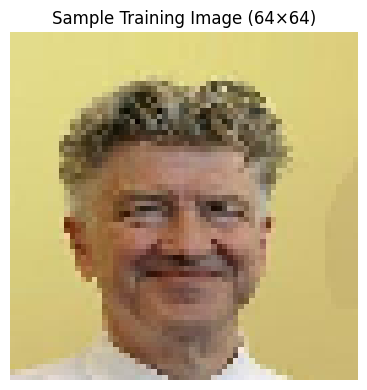

Image shape: (64, 64, 3)
Value range: [-1.00, 0.97]


In [6]:
# =============================================================================
# SAMPLE IMAGE VISUALIZATION
# =============================================================================

# Get a sample batch and display the first image
sample_batch = x_train[0][0]  # First batch, images only (not labels)
sample_image = sample_batch[0]  # First image in batch

# Convert from [-1, 1] to [0, 1] for display
sample_image_display = (sample_image + 1) / 2

plt.figure(figsize=(4, 4))
plt.imshow(sample_image_display)
plt.title(f'Sample Training Image ({IMAGE_SIZE}×{IMAGE_SIZE})')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Image shape: {sample_image.shape}")
print(f"Value range: [{sample_image.min():.2f}, {sample_image.max():.2f}]")

## 6. Model Architecture

Build the WGAN-GP model with the following architecture:

### Critic (Discriminator)
- 4 convolutional layers with LeakyReLU activation
- No batch normalization (as per WGAN-GP recommendations)
- Outputs unbounded scalar score (no sigmoid)

### Generator
- Dense layer to expand latent vector
- 4 transposed convolutional layers
- Batch normalization + LeakyReLU
- tanh output activation (images in [-1, 1])

In [7]:
# =============================================================================
# MODEL INSTANTIATION
# =============================================================================

gan = WGANGP(
    # Input dimensions
    input_dim=(IMAGE_SIZE, IMAGE_SIZE, 3),
    
    # Critic architecture
    critic_conv_filters=[64, 128, 256, 512],
    critic_conv_kernel_size=[5, 5, 5, 5],
    critic_conv_strides=[2, 2, 2, 2],
    critic_batch_norm_momentum=None,        # No batch norm in critic
    critic_activation='leaky_relu',
    critic_dropout_rate=None,
    critic_learning_rate=CRITIC_LR,
    
    # Generator architecture
    generator_initial_dense_layer_size=(4, 4, 512),
    generator_upsample=[1, 1, 1, 1],
    generator_conv_filters=[256, 128, 64, 3],
    generator_conv_kernel_size=[5, 5, 5, 5],
    generator_conv_strides=[2, 2, 2, 2],
    generator_batch_norm_momentum=0.9,
    generator_activation='leaky_relu',
    generator_dropout_rate=None,
    generator_learning_rate=GENERATOR_LR,
    
    # Training parameters
    optimiser='adam',
    grad_weight=GRAD_WEIGHT,
    z_dim=Z_DIM,
    batch_size=BATCH_SIZE,
)

# Save or load model based on mode
if MODE == 'build':
    gan.save(RUN_FOLDER)
    print("✓ New model built and saved")
else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))
    print("✓ Model weights loaded from checkpoint")

I0000 00:00:1768052095.443820    1842 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


✓ New model built and saved


### Critic Summary

The critic evaluates images and outputs a scalar "realness" score.

In [8]:
# Display critic architecture
gan.critic.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ critic_input (InputLayer)       │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_conv_0 (Conv2D)          │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_conv_1 (Conv2D)          │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_conv_2 (Conv2D)          │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ critic_conv_3 (Conv2D)          │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,314,753 (16.46 MB)

 Trainable params: 4,314,753 (16.46 MB)

 Non-trainable params: 0 (0.00 B)

### Generator Summary

The generator transforms random noise into realistic face images.

In [9]:
# Display generator architecture
gan.generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ generator_input (InputLayer)    │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8192)           │       827,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_conv_0                │ (None, 8, 8, 256)      │     3,277,056 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_conv_1                │ (None, 16, 16, 128)    │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_conv_2                │ (None, 32, 32, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_conv_3                │ (None, 64, 64, 3)      │         4,803 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,168,003 (19.71 MB)

 Trainable params: 5,150,723 (19.65 MB)

 Non-trainable params: 17,280 (67.50 KB)

## 7. Training

Train the WGAN-GP model using the custom training loop:

1. **Critic training** (n_critic times per iteration):
   - Compute Wasserstein loss on real and fake images
   - Compute gradient penalty on interpolated samples
   - Update critic weights

2. **Generator training** (once per iteration):
   - Generate fake images
   - Maximize critic score on fake images
   - Update generator weights

### W&B Per-Epoch Logging

The following metrics are logged to Weights & Biases **every epoch**:

| Metric | Description |
|--------|-------------|
| `epoch` | Current epoch number |
| `d_loss/total` | Total critic loss |
| `d_loss/real` | Critic loss on real images |
| `d_loss/fake` | Critic loss on fake images |
| `d_loss/gradient_penalty` | Gradient penalty term |
| `g_loss` | Generator loss |
| `wasserstein_distance` | Estimated Wasserstein distance |
| `d_g_ratio` | Critic/Generator loss ratio (training balance) |
| `generated_images` | Sample generated images (every N epochs) |

### Learning Rate Note
WGAN-GP uses **constant learning rate** (no scheduling) because:
- The gradient penalty ensures stable training throughout
- GANs seek a saddle point, not a minimum; LR decay can destabilize
- The original paper demonstrates 100K+ iterations without LR decay

In [10]:
# =============================================================================
# TRAINING
# =============================================================================

print(f"Starting WGAN-GP training...")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Critic updates per generator update: {N_CRITIC}")
print(f"  Gradient penalty weight: {GRAD_WEIGHT}")
print(f"")

gan.train(
    x_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    run_folder=RUN_FOLDER,
    print_every_n_batches=PRINT_EVERY_N_BATCHES,
    n_critic=N_CRITIC,
    using_generator=True,
    wandb_log=True,  # Enable per-epoch W&B logging
)

Starting WGAN-GP training...
  Epochs: 6000
  Batch size: 512
  Critic updates per generator update: 5
  Gradient penalty weight: 10



2026-01-10 13:35:01.740247: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2026-01-10 13:35:03.331256: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


0 (5, 1) [D loss: (-0.1)(R -2.4, F -2.6, GP 0.5)] [G loss: 5.0]


2026-01-10 13:35:18.193701: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fc6ec0058a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-10 13:35:18.193722: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2026-01-10 13:35:18.226521: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1768052119.958175    6493 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1 (5, 1) [D loss: (-57.0)(R -66.1, F -11.7, GP 2.1)] [G loss: 5.1]
2 (5, 1) [D loss: (-106.4)(R -167.7, F 10.4, GP 5.1)] [G loss: -18.4]
3 (5, 1) [D loss: (-124.7)(R -186.0, F 6.3, GP 5.5)] [G loss: -11.8]
4 (5, 1) [D loss: (-132.2)(R -213.5, F 7.2, GP 7.4)] [G loss: -4.2]
5 (5, 1) [D loss: (-129.0)(R -221.3, F 7.7, GP 8.5)] [G loss: 5.2]
6 (5, 1) [D loss: (-131.8)(R -219.5, F 10.8, GP 7.7)] [G loss: -6.4]
7 (5, 1) [D loss: (-122.8)(R -233.9, F 24.0, GP 8.7)] [G loss: 5.5]
8 (5, 1) [D loss: (-118.8)(R -257.8, F 37.5, GP 10.2)] [G loss: -16.4]
9 (5, 1) [D loss: (-125.5)(R -208.2, F 21.7, GP 6.1)] [G loss: -24.7]
10 (5, 1) [D loss: (-122.5)(R -204.5, F 18.6, GP 6.3)] [G loss: -21.6]
11 (5, 1) [D loss: (-121.5)(R -210.2, F 21.0, GP 6.8)] [G loss: -22.3]
12 (5, 1) [D loss: (-120.0)(R -214.3, F 24.4, GP 7.0)] [G loss: -17.5]
13 (5, 1) [D loss: (-125.0)(R -187.5, F 0.4, GP 6.2)] [G loss: -19.1]
14 (5, 1) [D loss: (-126.1)(R -198.4, F 6.7, GP 6.6)] [G loss: -18.8]
15 (5, 1) [D loss: (-114.6)(

## 8. Training Visualization

Visualize training metrics to assess model convergence and stability.

### 8.1 Wasserstein Distance

The Wasserstein distance measures the "distance" between the real and generated distributions. A **decreasing trend** indicates the generator is improving.

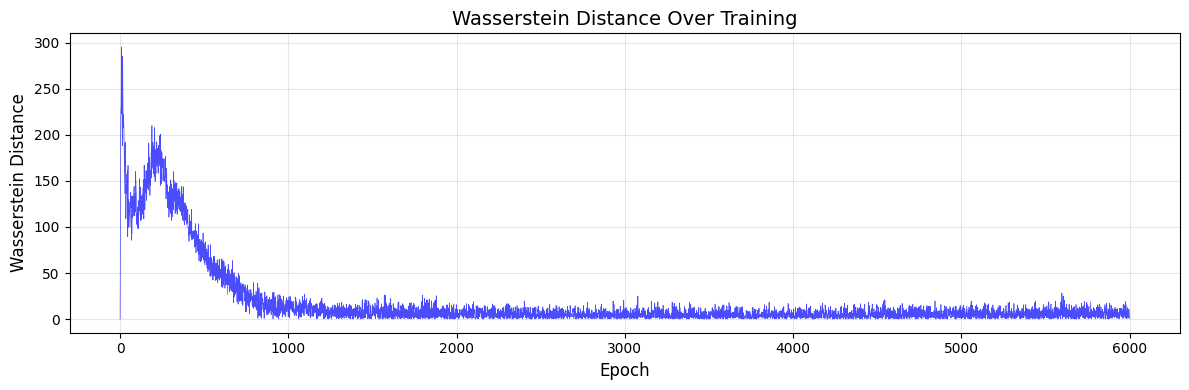

Initial W-distance: 0.2134
Final W-distance: 0.5949


In [12]:
# =============================================================================
# WASSERSTEIN DISTANCE PLOT
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 4))

# Wasserstein distance = D(real) - D(fake)
# Computed from critic losses: wasserstein_dist ≈ |d_loss_real - d_loss_fake|
wasserstein_dist = [abs(x[1] - x[2]) for x in gan.d_losses]

ax.plot(wasserstein_dist, color='blue', linewidth=0.5, alpha=0.7)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Wasserstein Distance', fontsize=12)
ax.set_title('Wasserstein Distance Over Training', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs(os.path.join(RUN_FOLDER, 'plots'), exist_ok=True)
plt.savefig(os.path.join(RUN_FOLDER, 'plots/wasserstein_distance.png'), dpi=150)
plt.show()

print(f"Initial W-distance: {wasserstein_dist[0]:.4f}")
print(f"Final W-distance: {wasserstein_dist[-1]:.4f}")

### 8.2 Critic Loss Components

The critic loss has three components:
- **Total Loss** (black): Sum of all components
- **Real Loss** (green): Should be negative (high scores for real images)
- **Fake Loss** (red): Should be positive (low scores for fake images)

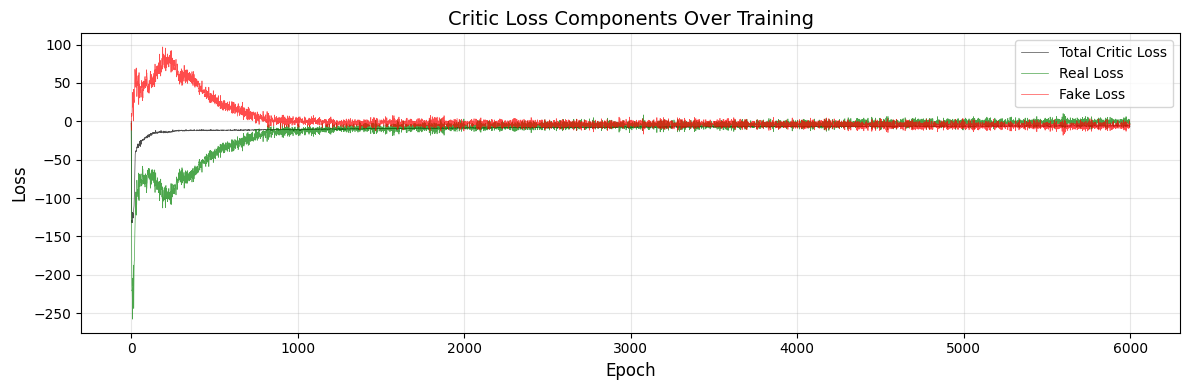

In [13]:
# =============================================================================
# CRITIC LOSS BREAKDOWN
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.5, 
        alpha=0.7, label='Total Critic Loss')
ax.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.5, 
        alpha=0.7, label='Real Loss')
ax.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.5, 
        alpha=0.7, label='Fake Loss')

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Critic Loss Components Over Training', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RUN_FOLDER, 'plots/critic_loss.png'), dpi=150)
plt.show()

### 8.3 Generator Loss

The generator loss is the negative of the critic's score on fake images. **Decreasing generator loss** means the generator is producing images that fool the critic.

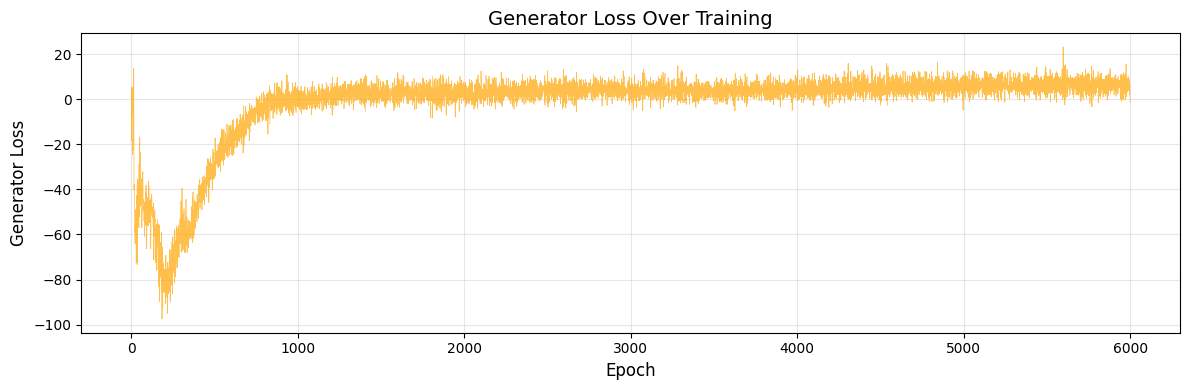

Initial G Loss: 4.9720
Final G Loss: -1.4435


In [14]:
# =============================================================================
# GENERATOR LOSS
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(gan.g_losses, color='orange', linewidth=0.5, alpha=0.7)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Generator Loss', fontsize=12)
ax.set_title('Generator Loss Over Training', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RUN_FOLDER, 'plots/generator_loss.png'), dpi=150)
plt.show()

print(f"Initial G Loss: {gan.g_losses[0]:.4f}")
print(f"Final G Loss: {gan.g_losses[-1]:.4f}")

### 8.4 Training Summary

WGAN-GP TRAINING SUMMARY
  Total Epochs      : 6000
  Total Batches     : 6000
  Batch Size        : 512
  Critic Updates    : 5 per generator update

  Final D Loss      : -6.4391
  Final G Loss      : -1.4435
  Final W-Distance  : 0.5949


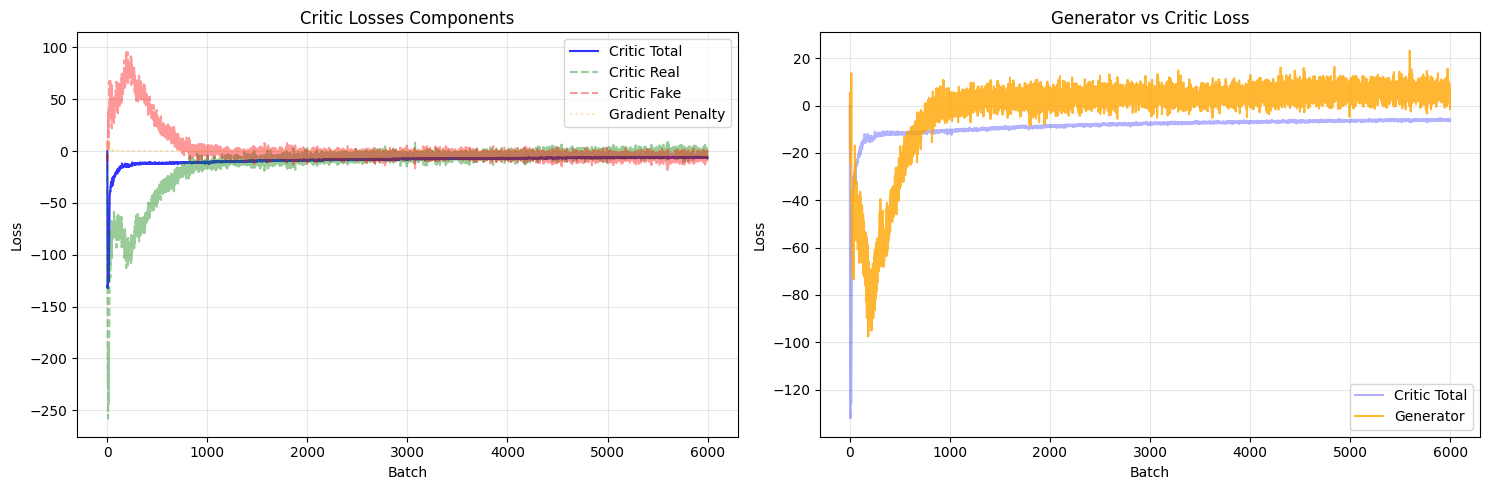

In [31]:
# =============================================================================
# 8.4 TRAINING DASHBOARD (Immediate Feedback)
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np

# 1. Print Summary Table
print("="*60)
print("WGAN-GP TRAINING SUMMARY")
print("="*60)
print(f"  Total Epochs      : {EPOCHS}")
print(f"  Total Batches     : {len(gan.d_losses)}")
print(f"  Batch Size        : {BATCH_SIZE}")
print(f"  Critic Updates    : {N_CRITIC} per generator update")
print(f"")
d_final = gan.d_losses[-1]
# Handle case where d_losses might be list of scalars or list of lists
d_val = d_final[0] if isinstance(d_final, (list, np.ndarray)) else d_final
g_val = gan.g_losses[-1]

print(f"  Final D Loss      : {d_val:.4f}")
print(f"  Final G Loss      : {g_val:.4f}")
# W-Distance estimate: |Real - Fake| if available
if isinstance(d_final, (list, np.ndarray)) and len(d_final) > 2:
    w_dist = abs(d_final[1] - d_final[2])
    print(f"  Final W-Distance  : {w_dist:.4f}")
print("="*60)

# 2. Inline Loss Plots
try:
    d_losses = np.array(gan.d_losses)
    g_losses = np.array(gan.g_losses)
    
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Critic Component Losses
    plt.subplot(1, 2, 1)
    if d_losses.ndim > 1 and d_losses.shape[1] >= 3:
        plt.plot(d_losses[:, 0], label='Critic Total', alpha=0.8, color='blue')
        plt.plot(d_losses[:, 1], label='Critic Real', alpha=0.4, linestyle='--', color='green')
        plt.plot(d_losses[:, 2], label='Critic Fake', alpha=0.4, linestyle='--', color='red')
        if d_losses.shape[1] > 3:
             plt.plot(d_losses[:, 3], label='Gradient Penalty', alpha=0.3, linestyle=':', color='orange')
    else:
        plt.plot(d_losses, label='Critic Total')
        
    plt.title('Critic Losses Components')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Generator vs Critic Total
    plt.subplot(1, 2, 2)
    d_total = d_losses[:, 0] if d_losses.ndim > 1 else d_losses
    plt.plot(d_total, label='Critic Total', alpha=0.3, color='blue')
    plt.plot(g_losses, label='Generator', alpha=0.8, color='orange')
    plt.title('Generator vs Critic Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Using simple plot due to data format: {e}")
    # Fallback plot
    plt.figure(figsize=(10,4))
    plt.plot(gan.d_losses, label='D Loss')
    plt.plot(gan.g_losses, label='G Loss')
    plt.legend()
    plt.show()


In [32]:
def generate_experiment_report(gan, run_folder, config):
    """
    Generates a comprehensive Markdown report compliant with the Stability Analysis Template.
    Includes Phase-wise metrics, Stability Indicators, and Quality Checks.
    Also generates and displays a batch of generated faces.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import tensorflow as tf
    import os
    from datetime import datetime
    from IPython.display import display, Image, Markdown

    # --- HELPER FUNCTIONS ---
    def get_phase_metrics(d_losses, g_losses, start_epoch, end_epoch):
        """Calculates start/end values and slope for a training phase."""
        if start_epoch >= len(d_losses) or end_epoch <= start_epoch:
            return None
        
        # Clamp end_epoch
        actual_end = min(end_epoch, len(d_losses))
        range_slice = slice(start_epoch, actual_end)
        
        d_range = d_losses[range_slice]
        g_range = g_losses[range_slice]
        
        # Simple start/end averaging (over first/last 5 points of phase for stability)
        d_start = np.mean(d_range[:5]) if len(d_range) > 5 else d_range[0]
        d_end = np.mean(d_range[-5:]) if len(d_range) > 5 else d_range[-1]
        g_start = np.mean(g_range[:5]) if len(g_range) > 5 else g_range[0]
        g_end = np.mean(g_range[-5:]) if len(g_range) > 5 else g_range[-1]
        
        # Slope (per epoch)
        epochs_in_phase = actual_end - start_epoch
        d_slope = (d_end - d_start) / epochs_in_phase if epochs_in_phase > 0 else 0
        g_slope = (g_end - g_start) / epochs_in_phase if epochs_in_phase > 0 else 0
        
        return {
            "range": f"{start_epoch}-{actual_end}",
            "d_change": f"{d_start:.2f} -> {d_end:.2f}",
            "g_change": f"{g_start:.2f} -> {g_end:.2f}",
            "d_slope": f"{d_slope:.4f}",
            "g_slope": f"{g_slope:.4f}"
        }

    # --- 1. PREPARE DATA ---
    epochs = config.get('EPOCHS', 0)
    d_losses = np.array([x[0] if isinstance(x, (list, tuple, np.ndarray)) else x for x in gan.d_losses])
    d_real = np.array([x[1] for x in gan.d_losses]) if len(gan.d_losses) > 0 and len(gan.d_losses[0]) > 1 else np.zeros_like(d_losses)
    d_fake = np.array([x[2] for x in gan.d_losses]) if len(gan.d_losses) > 0 and len(gan.d_losses[0]) > 2 else np.zeros_like(d_losses)
    g_losses = np.array(gan.g_losses)

    # --- 2. GENERATE VISUALIZATIONS ---
    viz_dir = os.path.join(run_folder, 'viz')
    os.makedirs(viz_dir, exist_ok=True)
    
    # A. LOSS CHART
    loss_chart_path = os.path.join(viz_dir, 'loss_chart.png')
    try:
        plt.figure(figsize=(12, 6))
        plt.plot(d_losses, label='Critic Loss', alpha=0.8)
        plt.plot(g_losses, label='Generator Loss', alpha=0.5)
        plt.title(f'WGAN-GP Training Stability ({epochs} Epochs)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(loss_chart_path)
        plt.close()
    except Exception as e:
        print(f"Error generating loss chart: {e}")
        loss_chart_path = None

    # B. GENERATED FACES
    faces_chart_path = os.path.join(viz_dir, 'generated_faces.png')
    try:
        z_dim = config.get('Z_DIM', 100)
        noise = tf.random.normal([36, z_dim])
        gen_imgs = gan.generator(noise, training=False)
        gen_imgs = 0.5 * gen_imgs + 0.5 # Rescale to [0, 1]
        
        fig, axs = plt.subplots(6, 6, figsize=(8, 8))
        cnt = 0
        for i in range(6):
            for j in range(6):
                axs[i,j].imshow(gen_imgs[cnt, :, :, :])
                axs[i,j].axis('off')
                cnt += 1
        plt.tight_layout()
        plt.savefig(faces_chart_path)
        plt.close()
    except Exception as e:
        print(f"Error generating faces: {e}")
        faces_chart_path = None

    # --- 3. ANALYZE STABILITY ---
    final_d = np.mean(d_losses[-10:]) if len(d_losses) > 10 else d_losses[-1]
    final_g = np.mean(g_losses[-10:]) if len(g_losses) > 10 else g_losses[-1]
    
    d_g_ratio = abs(final_d / (final_g + 1e-8))
    loss_var = np.var(d_losses[-100:]) if len(d_losses) > 100 else 0
    
    verdict = "✅ STABLE"
    if d_g_ratio < 0.01: 
        verdict = "❌ SUSPICIOUS (D/G Ratio Low)"
    if loss_var > 1.0:
        verdict = "⚠️ UNSTABLE (High Variance)"
    if abs(final_g) < 0.1:
        verdict = "❌ MODE COLLAPSE (G Loss -> 0)"

    phases = [
        ("Warmup", 0, 100),
        ("Early", 100, 1000),
        ("Mid", 1000, 4000),
        ("Late", 4000, 8000),
        ("Final", 8000, epochs)
    ]
    
    phase_rows = []
    for name, start, end in phases:
        metrics = get_phase_metrics(d_losses, g_losses, start, end)
        if metrics:
            phase_rows.append(f"| {name} | {metrics['range']} | {metrics['d_change']} | {metrics['g_change']} | {metrics['d_slope']} | {metrics['g_slope']} |")

    w_dist = abs(d_real - d_fake)
    final_w_dist = np.mean(w_dist[-10:]) if len(w_dist) > 10 else 0
    
    # --- 4. COMPOSE MARKDOWN REPORT ---
    date_str = datetime.now().strftime("%Y-%m-%d %H:%M")
    
    report = f"""
# Training Analysis Report: `{config.get('RUN_ID', 'N/A')}`

**Generated:** `{date_str}`  
**Total Epochs:** `{epochs}`  
**Final D Loss:** `{final_d:.4f}`  
**Final G Loss:** `{final_g:.4f}`  

---

## 1. Visualizations

### Generated Faces
![Generated Faces](viz/generated_faces.png)

### Training Loss
![Loss Chart](viz/loss_chart.png)

---

## 2. Training Verdict

| Metric | Value |
|--------|-------|
| **Stability** | **{verdict}** |
| **D/G Ratio** | `{d_g_ratio:.4f}` (>0.01 is good) |
| **Loss Variance** | `{loss_var:.6f}` (Lower is better) |
| **Final W-Dist** | `{final_w_dist:.4f}` (Higher is better initially) |

---

## 3. Configuration
| Parameter | Value |
|-----------|-------|
| Batch Size | {config.get('BATCH_SIZE', 'N/A')} |
| Critic LR | {config.get('CRITIC_LR', 'N/A')} |
| Generator LR | {config.get('GENERATOR_LR', 'N/A')} |
| Gradient Penalty | {config.get('GRAD_WEIGHT', 'N/A')} |
| n_critic | {config.get('N_CRITIC', 'N/A')} |

---

## 4. Training Progression (Phase-wise Metrics)

| Phase | Epoch Range | D Loss (Start -> End) | G Loss (Start -> End) | Δ D/epoch | Δ G/epoch |
|-------|-------------|-----------------------|-----------------------|-----------|-----------|
""" + "\n".join(phase_rows) + f"""

---

## 5. Stability Indicators

| Indicator | Status | Observation |
|-----------|--------|-------------|
| **Monotonicity** | {'✅' if loss_var < 0.5 else '⚠️'} | Variance: {loss_var:.6f} |
| **Balance** | {'✅' if 0.01 < d_g_ratio < 10 else '⚠️'} | D/G Ratio: {d_g_ratio:.4f} |
| **Mode Collapse** | {'✅' if abs(final_g) > 1.0 else '❌'} | G Loss magnitude: {abs(final_g):.2f} |

---

## 6. Notes
- **W-Distance**: Should grow initially and then stabilize. Current final: {final_w_dist:.4f}
- **Critic**: Should maintain ability to distinguish (D loss > 0).
"""
    
    # Save Report
    report_path = os.path.join(run_folder, 'experiment_report.md')
    with open(report_path, 'w') as f:
        f.write(report)
    
    print(f"✓ Report saved to {report_path}")
    
    # Upload to W&B if available
    try:
        import wandb
        if wandb.run is not None:
            wandb.save(report_path)
            if loss_chart_path:
                wandb.save(loss_chart_path)
            if faces_chart_path:
                wandb.save(faces_chart_path)
                # Explicitly log image to W&B media
                wandb.log({"generated_faces_final": [wandb.Image(faces_chart_path, caption="Final Generated Faces")]})
    except ImportError:
        pass
    except Exception as e:
        print(f"⚠️ W&B Upload failed: {e}")
    
    # Display in Notebook
    display(Markdown(report))
    if faces_chart_path:
        print("Displaying Generated Faces:")
        display(Image(filename=faces_chart_path))
    if loss_chart_path:
        print("Displaying Loss Chart:")
        display(Image(filename=loss_chart_path))


## 8.5 WGAN GP experiment report

✓ Report saved to ../run/gan/0003_img_align_celeba/experiment_report.md



# Training Analysis Report: `0003`

**Generated:** `2026-01-11 03:51`  
**Total Epochs:** `6000`  
**Final D Loss:** `-6.0056`  
**Final G Loss:** `5.4670`  

---

## 1. Visualizations

### Generated Faces
![Generated Faces](viz/generated_faces.png)

### Training Loss
![Loss Chart](viz/loss_chart.png)

---

## 2. Training Verdict

| Metric | Value |
|--------|-------|
| **Stability** | **✅ STABLE** |
| **D/G Ratio** | `1.0985` (>0.01 is good) |
| **Loss Variance** | `0.056198` (Lower is better) |
| **Final W-Dist** | `5.3404` (Higher is better initially) |

---

## 3. Configuration
| Parameter | Value |
|-----------|-------|
| Batch Size | 512 |
| Critic LR | 0.0002 |
| Generator LR | 0.0002 |
| Gradient Penalty | 10 |
| n_critic | 5 |

---

## 4. Training Progression (Phase-wise Metrics)

| Phase | Epoch Range | D Loss (Start -> End) | G Loss (Start -> End) | Δ D/epoch | Δ G/epoch |
|-------|-------------|-----------------------|-----------------------|-----------|-----------|
| Warmup | 0-100 | -84.06 -> -19.86 | -4.88 -> -50.47 | 0.6420 | -0.4559 |
| Early | 100-1000 | -19.10 -> -10.93 | -47.26 -> 0.04 | 0.0091 | 0.0525 |
| Mid | 1000-4000 | -10.64 -> -7.03 | 0.22 -> 4.96 | 0.0012 | 0.0016 |
| Late | 4000-6000 | -6.85 -> -6.07 | 4.37 -> 4.36 | 0.0004 | -0.0000 |

---

## 5. Stability Indicators

| Indicator | Status | Observation |
|-----------|--------|-------------|
| **Monotonicity** | ✅ | Variance: 0.056198 |
| **Balance** | ✅ | D/G Ratio: 1.0985 |
| **Mode Collapse** | ✅ | G Loss magnitude: 5.47 |

---

## 6. Notes
- **W-Distance**: Should grow initially and then stabilize. Current final: 5.3404
- **Critic**: Should maintain ability to distinguish (D loss > 0).


Displaying Generated Faces:


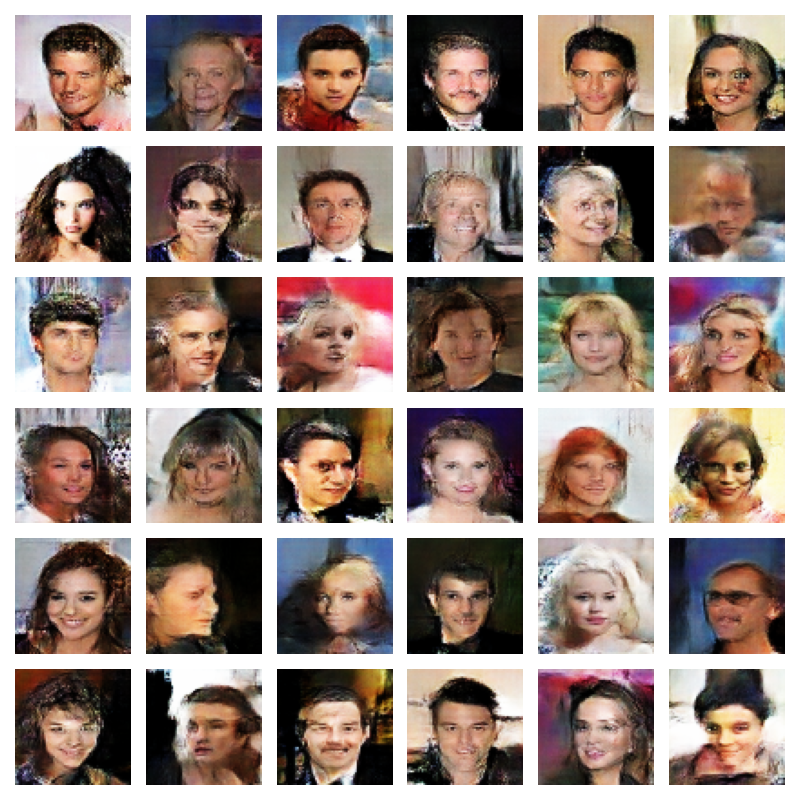

Displaying Loss Chart:


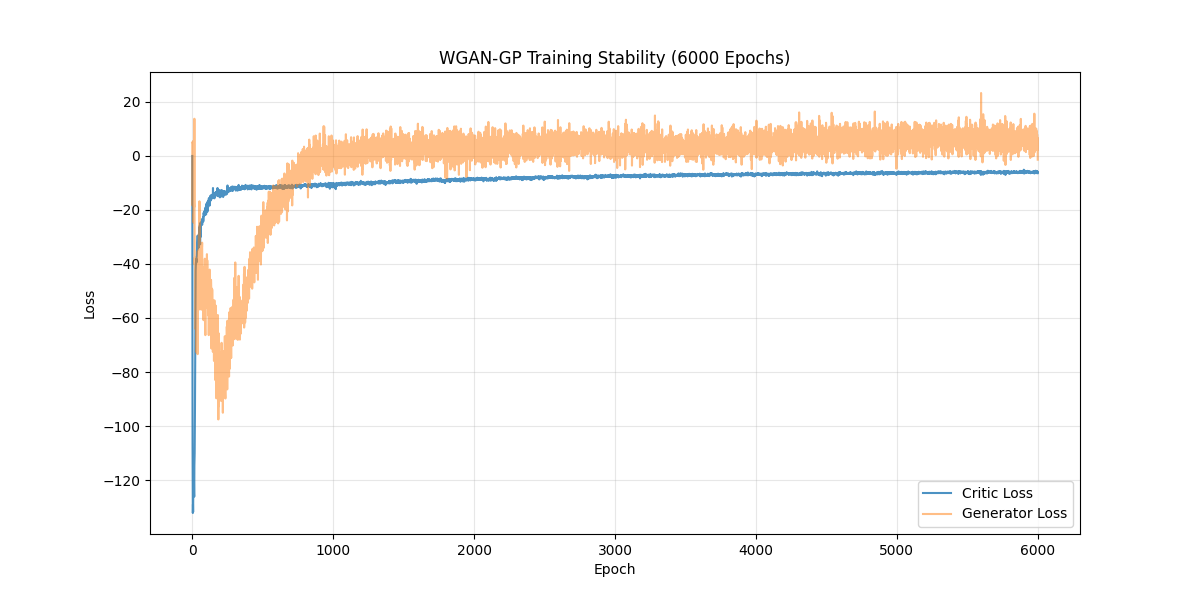

In [33]:
# Run Report Generation
if 'gan' in globals() and 'RUN_FOLDER' in globals():
    config = {
        'BATCH_SIZE': BATCH_SIZE if 'BATCH_SIZE' in globals() else 512,
        'EPOCHS': EPOCHS if 'EPOCHS' in globals() else 6000,
        'CRITIC_LR': CRITIC_LR if 'CRITIC_LR' in globals() else 0.0002,
        'GENERATOR_LR': GENERATOR_LR if 'GENERATOR_LR' in globals() else 0.0002,
        'GRAD_WEIGHT': GRAD_WEIGHT if 'GRAD_WEIGHT' in globals() else 10,
        'N_CRITIC': N_CRITIC if 'N_CRITIC' in globals() else 5,
        'Z_DIM': Z_DIM if 'Z_DIM' in globals() else 100,
        'RUN_ID': RUN_ID if 'RUN_ID' in globals() else 'unknown'
    }
    generate_experiment_report(gan, RUN_FOLDER, config)
else:
    print("Model 'gan' or 'RUN_FOLDER' not defined.")

### 8.6 Experimentation Log

Generate a comprehensive report of the training run, including configuration, phase-wise metrics, and stability analysis.

## 9. Finalize W&B Run

In [16]:
# =============================================================================
# W&B FINALIZATION
# =============================================================================

wandb.finish()
print("✓ W&B run finalized")

critic_updates,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
d_g_ratio,▁▁▁▁▁▁▁▁▁▂█▁▂▂▁▂▂▁▁▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
d_loss/fake,█▇▇▇▄▃▃▃▁▁▂▂▂▁▂▁▁▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▁▂▁▂▁▁▁▂
d_loss/gradient_penalty,█▄▄▄▃▄▃▃▄▃▂▁▂▂▂▂▁▁▁▂▁▂▂▁▂▂▁▁▁▁▂▁▂▂▁▁▁▁▁▂
d_loss/real,▁▃▅▆▆▇▇▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▇▇██▇▇██████▇██▇█
d_loss/total,▁▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
g_loss,▁▁▆▇█▇▇█▇█▇▇▇▇▇▇▇▇██▇▇▇▇▇█▇▇██▇▇▇▇███▇██
wasserstein_distance,▆▅▅█▆▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
critic_updates,5
d_g_ratio,4.46075


✓ W&B run finalized


## 10. Kernel Restart (GPU Memory Release)

> **Important:** TensorFlow/CUDA does not fully release GPU memory within a running Python process. Restarting the kernel is the only guaranteed way to free all GPU resources.

Run this cell only after all work is complete and saved.

In [ ]:
# =============================================================================
# CLEANUP: Restart kernel to fully release GPU memory
# =============================================================================
# Uncomment the lines below to restart the kernel after training is complete.
# This will clear all variables and outputs.

# import IPython
# print("Restarting kernel to release GPU memory...")
# IPython.Application.instance().kernel.do_shutdown(restart=True)